In [54]:
from sklearn.neighbors import KNeighborsClassifier
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [55]:
# Load 3d_library
library_3d = scipy.io.loadmat('3D_library.mat')
poses_2d = library_3d["s1_s9_2d_n"]
poses_3d = library_3d["s1_s9_3d"]

# Initialize NN model
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(poses_2d, range(0, len(poses_2d)))


KNeighborsClassifier(n_neighbors=1)

In [56]:
pairs = [
    [0, 1],
    [1, 2],
    [1, 5],
    [2, 3],
    [3, 4],
    [5, 6],
    [6, 7],
    [2, 8],
    [8, 9],
    [9, 10],
    [5, 11],
    [11, 12],
    [12, 13]
]

In [57]:
def nearest_neighbour(pose):
    min_distance = 9999
    index = -1
    for i in range(len(poses_2d)):
        el = poses_2d[i]
        distance = np.sum(np.square(pose - el))
        if distance < min_distance:
            min_distance = distance
            index = i
    return index

In [58]:
def transform_coordinates(prediction, img_height, img_width):
    
    # Transfrom to image space
    prediction[:,0] *= img_width
    prediction[:,1] *= img_height
    
    # Mapping between MPII --> 3D human 
    prediction[8,1] -=  20
    prediction[11,1] -= 20
    
    # Center of body is avg between left and right hip
    center =  0.5 * (pred_2d[8] + pred_2d[11])
    
    # Pose points relative to center
    relative_pose = pred_2d - center
    
    # Scale of pose
    scale = max(relative_pose[:, 1]) - min(relative_pose[:, 1])
    relative_pose /= scale
    
    return relative_pose

In [59]:
def knn(pred_2d):
    
    # Flatten relative pose
    flatten_pose = [item for sublist in pred_2d for item in sublist]
    
    # predict 3d_pose 
    idx =  nearest_neighbour(flatten_pose) 
    
    pose_3d = poses_3d[idx];
    pose_3d = np.reshape(pose_3d, (14, 3))
    return pose_3d

In [60]:
def draw_3d_pose(pose_3d):
    
    # View 1
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for pair in pairs:
        ax.plot([-pose_3d[pair[0]][1], -pose_3d[pair[1]][1]],
                [-pose_3d[pair[0]][2], -pose_3d[pair[1]][2]],
                [pose_3d[pair[0]][0], pose_3d[pair[1]][0]])
    
    plt.show()

In [62]:
def scale(pred_3d):
    # Scale the prediction
    scale = (max(pred_3d[:,1]) - min(pred_3d[:,1]))/(max(pred_2d[:,1])-min(pred_2d[:,1]))
    for i in range(len(pred_2d)):
        pred_3d[i] = np.append(pred_2d[i], pred_3d[i][2]/scale)
    
    # self-defined ground plane
    pred_3d[:,2] = pred_3d[:,2] - np.min(pred_3d[:,2]) + 1300
    return pred_3d

[[1042.96875      61.03125037 1710.57225096]
 [1089.84375     318.84375046 1808.4293414 ]
 [ 972.65625     373.53124984 1916.87160945]
 [1011.71875     482.90624991 2046.03663138]
 [ 996.09375     373.53124984 1821.49086174]
 [1207.03125     365.71875012 1717.86275121]
 [1261.71875     576.65625055 1500.76634719]
 [1246.09375     459.46874942 1300.        ]
 [1050.78125     736.34374945 1951.99926123]
 [ 824.21875     842.28125037 1747.03765702]
 [ 863.28125    1154.78124983 1988.06849651]
 [1175.78125     759.78124994 1863.63511149]
 [1332.03125    1100.09375046 1885.98975277]
 [1597.65625    1139.15625039 2218.62039701]]


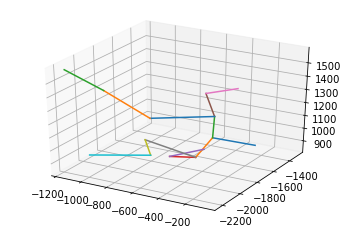

In [63]:
pred_2d = np.array([[0.521484375, 0.045784884], [0.544921875, 0.239192611], [0.486328125, 0.280218492], [0.505859375, 0.362270255],
           [0.498046875, 0.280218492], [0.603515625, 0.274357652], [0.630859375, 0.432600338], 
           [0.623046875, 0.344687734], [0.525390625, 0.567399662], [0.412109375, 0.631868905],
           [0.431640625, 0.866302513], [0.587890625, 0.584982183], [0.666015625, 0.825276632], [0.798828125, 0.854580833]])

img = cv2.imread('./2d output/5.jpg', 0) 

relative_pred = transform_coordinates(pred_2d, img.shape[0], img.shape[1])
pred_3d = knn(relative_pred)
pred_3d = scale(pred_3d)
print(pred_3d)
draw_3d_pose(pred_3d)